In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from tabulate import tabulate
import seaborn as sns
import scikitplot as skplt
from numpy import percentile
import math
from numpy import arange
import IPython.display as ipd
import matplotlib.lines as mlines

#pandas
from pandas.plotting import parallel_coordinates
import datetime

#sklearn
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import learning_curve

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

#scikitplot
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_cumulative_gain

#tslearn
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix

#mlxtend
from mlxtend.plotting import plot_decision_regions

#matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot

#seaborn
import seaborn as sns

#scipy
import scipy.stats as stats
from scipy.stats import shapiro, mannwhitneyu, normaltest, kstest
from scipy.stats import boxcox, yeojohnson
from scipy.spatial.distance import euclidean, cityblock, cosine, minkowski
from scipy.spatial.distance import cdist

#matrixprofile
import matrixprofile
from matrixprofile import *
from matrixprofile.discords import discords

In [38]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples, davies_bouldin_score
import numpy as np
import scipy.stats as stats
import collections
import math

from kmodes.kmodes import KModes

In [39]:
def inertia(number_of_clusters, X, labels):
    
    manual_SSE = 0
    for i in range(number_of_clusters):
        cluster = X[labels == i]
        if len(cluster) > 0:
                clusterMean = cluster.mean(axis = 0)
                manual_SSE += ((cluster - clusterMean) ** 2).sum()
                
    return manual_SSE

In [40]:
def cluster_insight(df):
    
    cluster_diz = pd.DataFrame(columns = ["Studio_Recording", "Live_Recording"], \
                                index = ["Cluster {}".format(str(i)) for i in np.unique(df['Labels'])])
    
    tot_entropies = []
    dim_clusters = []
    max_cluster = 0

    for i in np.unique(df['Labels']):

        cluster_list = list(df[df['Labels'] == i]['album_type'])

        counter = collections.Counter(cluster_list)

        cluster_diz.loc["Cluster {}".format(str(i)), 'Studio_Recording'] = counter[0]
        cluster_diz.loc["Cluster {}".format(str(i)), 'Live_Recording'] = counter[1]

        #cluster_diz.loc["Cluster {}".format(str(i)), 'Tot_Cluster'] = cluster_diz.loc["Cluster {}".format(str(i)), ['Studio_Recording', 'Live_Recording']].sum()

        lista = cluster_diz.loc['Cluster {}'.format(str(i)), ['Studio_Recording', 'Live_Recording']].values.tolist()
        tot = sum(lista)
        cluster_diz.loc["Cluster {}".format(str(i)), 'Tot_Cluster'] = tot
        dim_clusters.append(tot)

        '''
        Entropia singola: -(sommatoria di (pij log2 pij) per tutte le classi all'interno di un cluster.
        --> pij = mij/mj dove mj è il numero di valori nel cluster j e mij è il numero di valori della classe i
        nel cluster j.
        '''
        entropy_single = -sum([(x/tot)*math.log2(x/tot) for x in lista if x != 0])
        cluster_diz.loc["Cluster {}".format(str(i)), 'Entropy'] = "%.4f" %(entropy_single)
        tot_entropies.append(entropy_single)


        '''
        Purity singola: etichetta della classe più frequente/numero di valori nel cluster
        '''
        purity_single = max(lista)/tot
        cluster_diz.loc["Cluster {}".format(str(i)), 'Purity'] = "%.4f" %(purity_single)

        max_cluster += max(lista)


    new_row = pd.Series(cluster_diz[['Studio_Recording', 'Live_Recording', 'Tot_Cluster']].sum(axis=0).astype(int), name = "Total")
    cluster_diz = cluster_diz.append(new_row, ignore_index=False)

    '''
    Entropia complessiva: sommatoria delle entropie di ogni cluster pesate per la dimensione di ogni cluster.
    --> (mj/m) * ej --> dove mj è la dimensione del cluster j e m è il numero totale di punti. 
    '''

    last_tot = cluster_diz.loc['Total', 'Tot_Cluster']
    tot_entropy = 0

    for entropy, dim in zip(tot_entropies, dim_clusters):
        tot_entropy+=(entropy*(dim/last_tot))

    cluster_diz.loc["Total", 'Entropy'] = "%.4f" %(tot_entropy)

    '''
    Purity complessiva: sommatoria delle classi "corrette" (il valore più alto) di ogni cluster, divisa per il
    numero totale di valori.
    '''

    tot_purity = max_cluster/last_tot
    cluster_diz.loc["Total", 'Purity'] = "%.4f" %(tot_purity)



    cluster_diz['Tot_Cluster'] = cluster_diz['Tot_Cluster'].astype(int)

    ipd.display(cluster_diz)

In [43]:
def run_kmodes(X):
    
    max_k = 20
    sse_list = list()
    silhouette = list()
    calinski = list()
    bouldin = list()
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 10))

    for k in range(2, max_k+1):
        
        #-----------------------------------run algorithm------------------------------------#
        
        km = KModes(n_clusters = k, init = 'Huang', n_init = 5, verbose = 0)
        clusters = km.fit_predict(X)

        #-----------------------------------calculate metrics--------------------------------#
        
        n_clusters = len(np.unique(km.labels_))
        
        sse = inertia(n_clusters, X, km.labels_)
        sse_list.append(sse)
        
        sil = silhouette_score(X, km.labels_)
        silhouette.append(sil)
        
        cal = calinski_harabasz_score(X, km.labels_)
        calinski.append(cal)
        
        boul = davies_bouldin_score(X, km.labels_)
        bouldin.append(boul)
        
        print("k: ", k)
        print ('SSE: ', sse)
        print ('Silhouette Score: ', sil)
        print ("Calinski - Harabaz Score: ", cal)
        print ("Davies - Bouldin Score: ", boul)
        print()
        print("---------------------------------")
        print()
        
        
    
    index = [i for i in range(2, max_k + 1)]
    
    ax[0, 0].plot(range(2, len(sse_list) + 2), sse_list)
    ax[0, 0].set_ylabel('SSE', fontsize=15)
    ax[0, 0].set_xlabel('K', fontsize=15)

    ax[0, 1].plot(range(2, len(silhouette) + 2), silhouette)
    ax[0, 1].set_ylabel('SIL', fontsize=15)
    ax[0, 1].set_xlabel('K', fontsize=15)

    ax[1, 0].plot(range(2, len(calinski) + 2), calinski)
    ax[1, 0].set_ylabel('CAL', fontsize=15)
    ax[1, 0].set_xlabel('K', fontsize=15)

    ax[1, 1].plot(range(2, len(bouldin) + 2), bouldin)
    ax[1, 1].set_ylabel('BOUL', fontsize=15)
    ax[1, 1].set_xlabel('K', fontsize=15)
    
    for axis in ax.flat:
        axis.xaxis.set_major_locator(MultipleLocator(5))
        axis.xaxis.set_minor_locator(MultipleLocator(1))
        axis.tick_params(which='major', length=9)
        axis.tick_params(which='minor', length=7, color='r')

    plt.show()
    fig.tight_layout()

<h2>All categorical features</h2>

In [6]:
df_complete = pd.read_csv('group_20_fma_numeric.csv', index_col = 0)

In [11]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103708 entries, 2 to 155320
Data columns (total 56 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   chroma_cens_02                       103708 non-null  float64
 1   chroma_cens_04                       103708 non-null  float64
 2   chroma_cens_06                       103708 non-null  float64
 3   chroma_cens_07                       103708 non-null  float64
 4   chroma_cens_09                       103708 non-null  float64
 5   chroma_cens_11                       103708 non-null  float64
 6   chroma_stft_05                       103708 non-null  float64
 7   chroma_stft_08                       103708 non-null  float64
 8   chroma_stft_10                       103708 non-null  float64
 9   chroma_stft_12                       103708 non-null  float64
 10  mfcc_02                              103708 non-null  float64
 11  mfcc_03      

In [8]:
numeric_columns = []  # continous variables
for column_name in df_complete.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 38


In [9]:
categoric_columns = []  # ordinal or categorical variables
for column_name in df_complete.columns:
    if ("track_genre_top" in column_name) or  \
          ("track_date_created_year" in column_name) or \
            ("track_date_created_season" in column_name):
                categoric_columns.append(column_name)
print("categoric_columns", len(categoric_columns))

categoric_columns 18


In [12]:
album_type = df_complete['album_type']

In [13]:
df_complete = df_complete[categoric_columns]

In [15]:
df_complete['album_type'] = album_type

In [16]:
df_complete

,track_genre_top_Hip-Hop,track_genre_top_Pop,track_genre_top_Experimental,track_genre_top_Folk,track_genre_top_Jazz,track_genre_top_Rock,track_genre_top_Electronic,track_genre_top_Spoken,track_genre_top_International,track_genre_top_Soul-RnB,track_genre_top_Blues,track_genre_top_Classical,track_genre_top_Country,track_genre_top_Old-Time_/_Historic,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_date_created_year,track_date_created_season,album_type
track_id,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0
10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0
20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,1,1
155317,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,1,1
155318,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,1,1


In [66]:
df_orig = pd.read_csv('group_20_fma_numeric.csv', index_col = 0)

In [67]:
album_type_orig = df_orig['album_type']

In [68]:
df_orig = df_orig[categoric_columns]

In [69]:
df_orig['album_type'] = album_type_orig

In [70]:
df_orig

,track_genre_top_Hip-Hop,track_genre_top_Pop,track_genre_top_Experimental,track_genre_top_Folk,track_genre_top_Jazz,track_genre_top_Rock,track_genre_top_Electronic,track_genre_top_Spoken,track_genre_top_International,track_genre_top_Soul-RnB,track_genre_top_Blues,track_genre_top_Classical,track_genre_top_Country,track_genre_top_Old-Time_/_Historic,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_date_created_year,track_date_created_season,album_type
track_id,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0
10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0
20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,1,1
155317,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,1,1
155318,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,1,1


In [84]:
df_orig.to_csv("df_categorical.csv")

In [32]:
df = df_complete[[col for col in df_complete.columns if col != "album_type"]]

In [33]:
df

,track_genre_top_Hip-Hop,track_genre_top_Pop,track_genre_top_Experimental,track_genre_top_Folk,track_genre_top_Jazz,track_genre_top_Rock,track_genre_top_Electronic,track_genre_top_Spoken,track_genre_top_International,track_genre_top_Soul-RnB,track_genre_top_Blues,track_genre_top_Classical,track_genre_top_Country,track_genre_top_Old-Time_/_Historic,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_date_created_year,track_date_created_season
track_id,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,1
155317,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,1
155318,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,1


In [35]:
column_names = ['track_date_created_year', 'track_date_created_season']
                
for column_name in column_names:
    
    # define the scaler model
    scaler = MinMaxScaler()
    # fit the model on the feature to normale its values and transform it
    df[column_name] = scaler.fit_transform(df[column_name].values.reshape(-1,1))[:, 0]

df

<ipython-input-35-1e419e38d3fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = scaler.fit_transform(df[column_name].values.reshape(-1,1))[:, 0]
<ipython-input-35-1e419e38d3fe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = scaler.fit_transform(df[column_name].values.reshape(-1,1))[:, 0]


,track_genre_top_Hip-Hop,track_genre_top_Pop,track_genre_top_Experimental,track_genre_top_Folk,track_genre_top_Jazz,track_genre_top_Rock,track_genre_top_Electronic,track_genre_top_Spoken,track_genre_top_International,track_genre_top_Soul-RnB,track_genre_top_Blues,track_genre_top_Classical,track_genre_top_Country,track_genre_top_Old-Time_/_Historic,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_date_created_year,track_date_created_season
track_id,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.666667
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.666667
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.666667
10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.666667
20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,0.000000
155317,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,0.000000
155318,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,0.000000


In [44]:
df_copia = df.copy()

In [36]:
df.describe()

,track_genre_top_Hip-Hop,track_genre_top_Pop,track_genre_top_Experimental,track_genre_top_Folk,track_genre_top_Jazz,track_genre_top_Rock,track_genre_top_Electronic,track_genre_top_Spoken,track_genre_top_International,track_genre_top_Soul-RnB,track_genre_top_Blues,track_genre_top_Classical,track_genre_top_Country,track_genre_top_Old-Time_/_Historic,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_date_created_year,track_date_created_season
count,103708.000000,103708.00000,103708.000000,103708.000000,103708.000000,103708.000000,103708.00000,103708.000000,103708.000000,103708.000000,103708.000000,103708.000000,103708.000000,103708.000000,103708.000000,103708.000000,103708.000000,103708.000000
mean,0.076021,0.04962,0.223994,0.056514,0.011745,0.233222,0.17450,0.006808,0.028542,0.014840,0.001880,0.043835,0.007376,0.005284,0.002411,0.063409,0.517498,0.509045
std,0.265033,0.21716,0.416920,0.230914,0.107734,0.422884,0.37954,0.082227,0.166515,0.120912,0.043322,0.204728,0.085569,0.072500,0.049039,0.243698,0.278979,0.389874
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.555556,0.666667
75%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.777778,1.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
df = df.values

k:  2
SSE:  102754.2049730051
Silhouette Score:  0.09236788593254143
Calinski - Harabaz Score:  8930.46400804486
Davies - Bouldin Score:  3.1194696450471975

---------------------------------

k:  3
SSE:  98606.18162424516
Silhouette Score:  0.04944780772401369
Calinski - Harabaz Score:  6834.280670172708
Davies - Bouldin Score:  4.805056281718678

---------------------------------

k:  4
SSE:  92841.6648938453
Silhouette Score:  0.045297912259779444
Calinski - Harabaz Score:  6985.3518560408465
Davies - Bouldin Score:  4.961817756805474

---------------------------------

k:  5
SSE:  89788.64470987541
Silhouette Score:  -0.012866547775070583
Calinski - Harabaz Score:  6298.635219849236
Davies - Bouldin Score:  3.6998053866585727

---------------------------------

k:  6
SSE:  71005.06164419267
Silhouette Score:  0.1018298354985097
Calinski - Harabaz Score:  11858.470084177172
Davies - Bouldin Score:  2.0558845975465565

---------------------------------

k:  7
SSE:  82607.5822773028
S

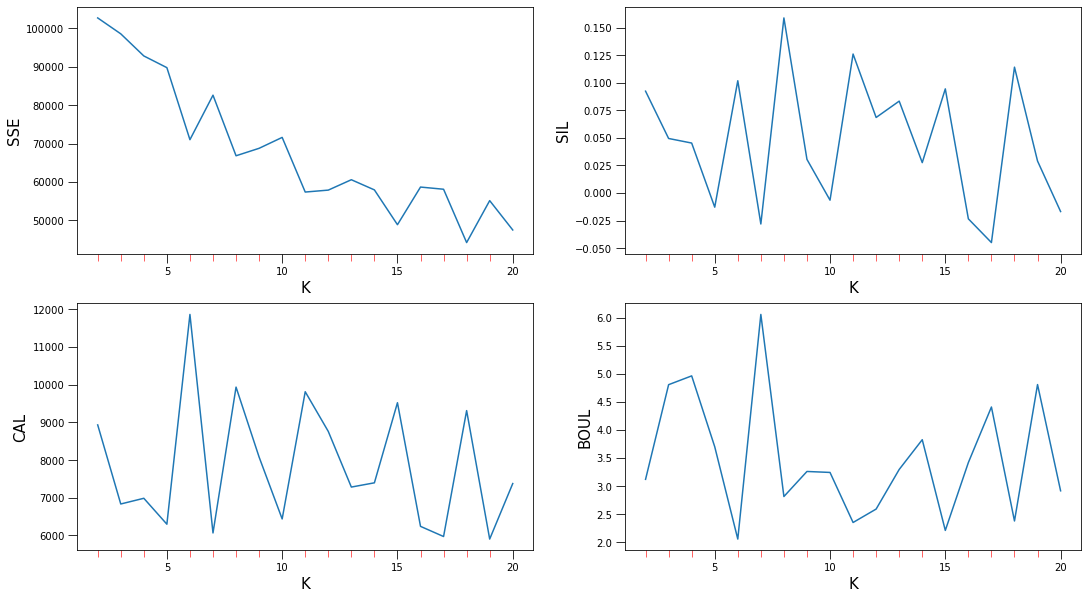

In [48]:
run_kmodes(df)

In [49]:
km = KModes(n_clusters = 8, init = 'Huang', n_init = 20, verbose = 0)
clusters = km.fit_predict(df)

n_clusters = len(np.unique(km.labels_))
        
sse = inertia(n_clusters, df, km.labels_)
       
sil = silhouette_score(df, km.labels_)
        
cal = calinski_harabasz_score(df, km.labels_)
       
boul = davies_bouldin_score(df, km.labels_)
 
print ('SSE: ', sse)
print ('Silhouette Score: ', sil)
print ("Calinski - Harabaz Score: ", cal)
print ("Davies - Bouldin Score: ", boul)

SSE:  78842.79909633944
Silhouette Score:  -0.016524638278047492
Calinski - Harabaz Score:  6155.471876629938
Davies - Bouldin Score:  3.345060770534368


In [50]:
df_complete['Labels'] = km.labels_

In [51]:
cluster_insight(df_complete)

,Studio_Recording,Live_Recording,Tot_Cluster,Entropy,Purity
Cluster 0,22569,3469,26038,0.5662,0.8668
Cluster 1,17172,1676,18848,0.4329,0.9111
Cluster 2,16196,1741,17937,0.4596,0.9029
Cluster 3,8343,181,8524,0.1483,0.9788
Cluster 4,8425,1077,9502,0.5099,0.8867
Cluster 5,6552,2779,9331,0.8786,0.7022
Cluster 6,7164,246,7410,0.2102,0.9668
Cluster 7,5762,356,6118,0.3202,0.9418
Total,92183,11525,103708,0.4722,0.8889


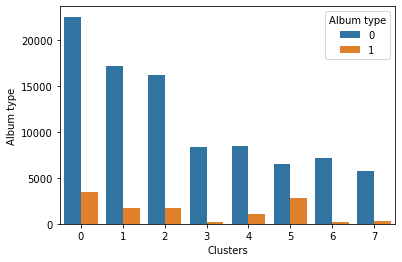

In [53]:
b = sns.countplot(x=df_complete['Labels'], data=df_complete, hue = df_complete['album_type'])
b.set_xlabel("Clusters")
b.set_ylabel("Album type")
b.tick_params()
b.legend_.set_title('Album type')
b.grid(False)

<h2>Feature selection</h2>

In [54]:
df = df_complete[['track_date_created_year', 'track_date_created_season']]

In [55]:
df

,track_date_created_year,track_date_created_season
track_id,,
2,1,3
3,1,3
5,1,3
10,1,3
20,1,3
...,...,...
155316,10,1
155317,10,1
155318,10,1


In [56]:
for column_name in df.columns:
    
    # define the scaler model
    scaler = MinMaxScaler()
    # fit the model on the feature to normale its values and transform it
    df[column_name] = scaler.fit_transform(df[column_name].values.reshape(-1,1))[:, 0]

df

<ipython-input-56-c8d7ada126f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = scaler.fit_transform(df[column_name].values.reshape(-1,1))[:, 0]
<ipython-input-56-c8d7ada126f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = scaler.fit_transform(df[column_name].values.reshape(-1,1))[:, 0]


,track_date_created_year,track_date_created_season
track_id,,
2,0.0,0.666667
3,0.0,0.666667
5,0.0,0.666667
10,0.0,0.666667
20,0.0,0.666667
...,...,...
155316,1.0,0.000000
155317,1.0,0.000000
155318,1.0,0.000000


In [57]:
df.describe()

,track_date_created_year,track_date_created_season
count,103708.000000,103708.000000
mean,0.517498,0.509045
std,0.278979,0.389874
min,0.000000,0.000000
25%,0.222222,0.000000
50%,0.555556,0.666667
75%,0.777778,1.000000
max,1.000000,1.000000


In [58]:
df = df.values

k:  2
SSE:  16059.118100485815
Silhouette Score:  0.2875367803813084
Calinski - Harabaz Score:  50215.27786344731
Davies - Bouldin Score:  1.1633381402077918

---------------------------------

k:  3
SSE:  13711.876371239709
Silhouette Score:  0.22415539201448442
Calinski - Harabaz Score:  38281.631806320605
Davies - Bouldin Score:  1.9868645132430487

---------------------------------

k:  4
SSE:  12871.293884477363
Silhouette Score:  0.1532848428935379
Calinski - Harabaz Score:  29445.049281801246
Davies - Bouldin Score:  2.3081237679566957

---------------------------------

k:  5
SSE:  14950.98418624928
Silhouette Score:  0.1397729966918438
Calinski - Harabaz Score:  15405.450063140086
Davies - Bouldin Score:  5.905860336438308

---------------------------------

k:  6
SSE:  10237.352324288559
Silhouette Score:  0.1624398065160366
Calinski - Harabaz Score:  27548.348121608735
Davies - Bouldin Score:  1.4013010299562667

---------------------------------

k:  7
SSE:  13306.795630423

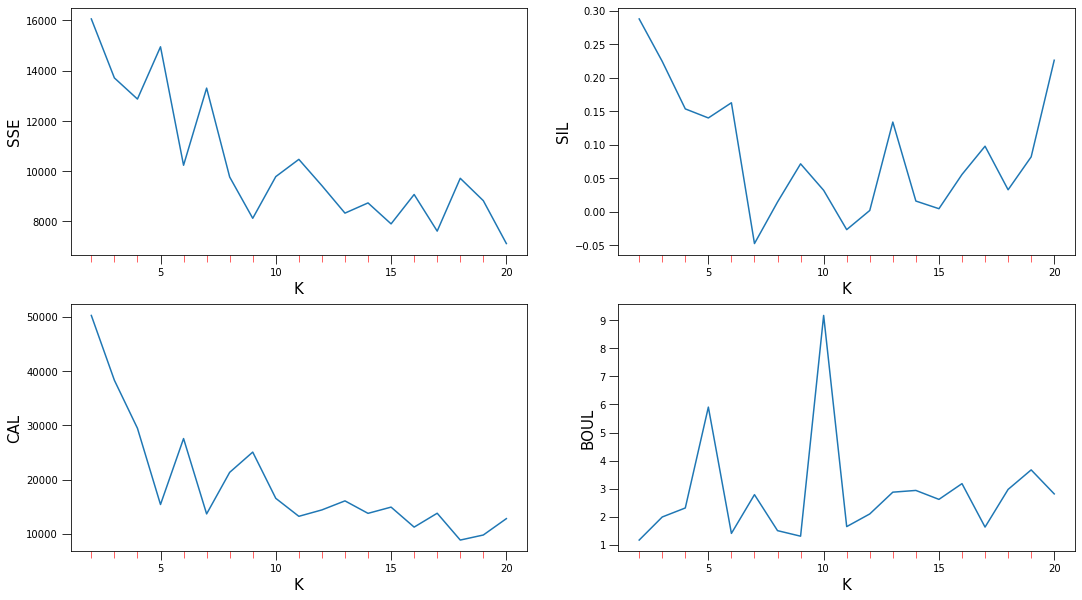

In [59]:
run_kmodes(df)

In [60]:
km = KModes(n_clusters = 6, init = 'Huang', n_init = 20, verbose = 0)
clusters = km.fit_predict(df)

n_clusters = len(np.unique(km.labels_))
        
sse = inertia(n_clusters, df, km.labels_)
       
sil = silhouette_score(df, km.labels_)
        
cal = calinski_harabasz_score(df, km.labels_)
       
boul = davies_bouldin_score(df, km.labels_)
 
print ('SSE: ', sse)
print ('Silhouette Score: ', sil)
print ("Calinski - Harabaz Score: ", cal)
print ("Davies - Bouldin Score: ", boul)

SSE:  12460.623237857859
Silhouette Score:  0.1408889700802808
Calinski - Harabaz Score:  18932.48941999336
Davies - Bouldin Score:  2.6467584528109906


In [61]:
df_complete['Labels'] = km.labels_

In [62]:
cluster_insight(df_complete)

,Studio_Recording,Live_Recording,Tot_Cluster,Entropy,Purity
Cluster 0,26257,4713,30970,0.6153,0.8478
Cluster 1,10745,1421,12166,0.5201,0.8832
Cluster 2,17279,2313,19592,0.5238,0.8819
Cluster 3,20151,1056,21207,0.2855,0.9502
Cluster 4,5071,1299,6370,0.7297,0.7961
Cluster 5,12680,723,13403,0.3029,0.9461
Total,92183,11525,103708,0.4860,0.8889


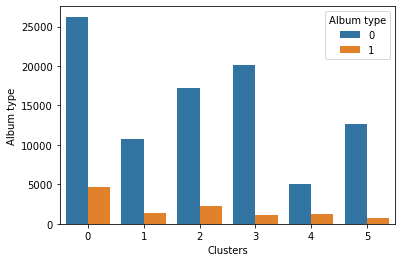

In [63]:
b = sns.countplot(x=df_complete['Labels'], data=df_complete, hue = df_complete['album_type'])
b.set_xlabel("Clusters")
b.set_ylabel("Album type")
b.tick_params()
b.legend_.set_title('Album type')
b.grid(False)

<h2>Feature selection 2</h2>

In [71]:
df = df_orig.copy()

del df['track_date_created_year']
del df['track_date_created_season']
del df['album_type']

In [72]:
df

,track_genre_top_Hip-Hop,track_genre_top_Pop,track_genre_top_Experimental,track_genre_top_Folk,track_genre_top_Jazz,track_genre_top_Rock,track_genre_top_Electronic,track_genre_top_Spoken,track_genre_top_International,track_genre_top_Soul-RnB,track_genre_top_Blues,track_genre_top_Classical,track_genre_top_Country,track_genre_top_Old-Time_/_Historic,track_genre_top_Easy_Listening,track_genre_top_Instrumental
track_id,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
155317,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
155318,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [73]:
df.describe()

,track_genre_top_Hip-Hop,track_genre_top_Pop,track_genre_top_Experimental,track_genre_top_Folk,track_genre_top_Jazz,track_genre_top_Rock,track_genre_top_Electronic,track_genre_top_Spoken,track_genre_top_International,track_genre_top_Soul-RnB,track_genre_top_Blues,track_genre_top_Classical,track_genre_top_Country,track_genre_top_Old-Time_/_Historic,track_genre_top_Easy_Listening,track_genre_top_Instrumental
count,103708.000000,103708.00000,103708.000000,103708.000000,103708.000000,103708.000000,103708.00000,103708.000000,103708.000000,103708.000000,103708.000000,103708.000000,103708.000000,103708.000000,103708.000000,103708.000000
mean,0.076021,0.04962,0.223994,0.056514,0.011745,0.233222,0.17450,0.006808,0.028542,0.014840,0.001880,0.043835,0.007376,0.005284,0.002411,0.063409
std,0.265033,0.21716,0.416920,0.230914,0.107734,0.422884,0.37954,0.082227,0.166515,0.120912,0.043322,0.204728,0.085569,0.072500,0.049039,0.243698
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [74]:
df = df.values

k:  2
SSE:  66641.79012897934
Silhouette Score:  0.35740137488149853
Calinski - Harabaz Score:  32875.420053607384
Davies - Bouldin Score:  0.8334564050498993

---------------------------------

k:  3
SSE:  60369.606884033594
Silhouette Score:  0.4178807942776588
Calinski - Harabaz Score:  23532.640245985007
Davies - Bouldin Score:  0.8188463712055625

---------------------------------

k:  4
SSE:  40631.30462026571
Silhouette Score:  0.6082065960841989
Calinski - Harabaz Score:  40102.29736903245
Davies - Bouldin Score:  0.8097667062448527

---------------------------------

k:  5
SSE:  43030.25238179565
Silhouette Score:  0.5850752651942464
Calinski - Harabaz Score:  26954.2967347292
Davies - Bouldin Score:  0.7631352055424026

---------------------------------

k:  6
SSE:  26484.153030192447
Silhouette Score:  0.744621462354792
Calinski - Harabaz Score:  47992.62121321633
Davies - Bouldin Score:  0.637384543442908

---------------------------------

k:  7
SSE:  20685.556746997834
Si

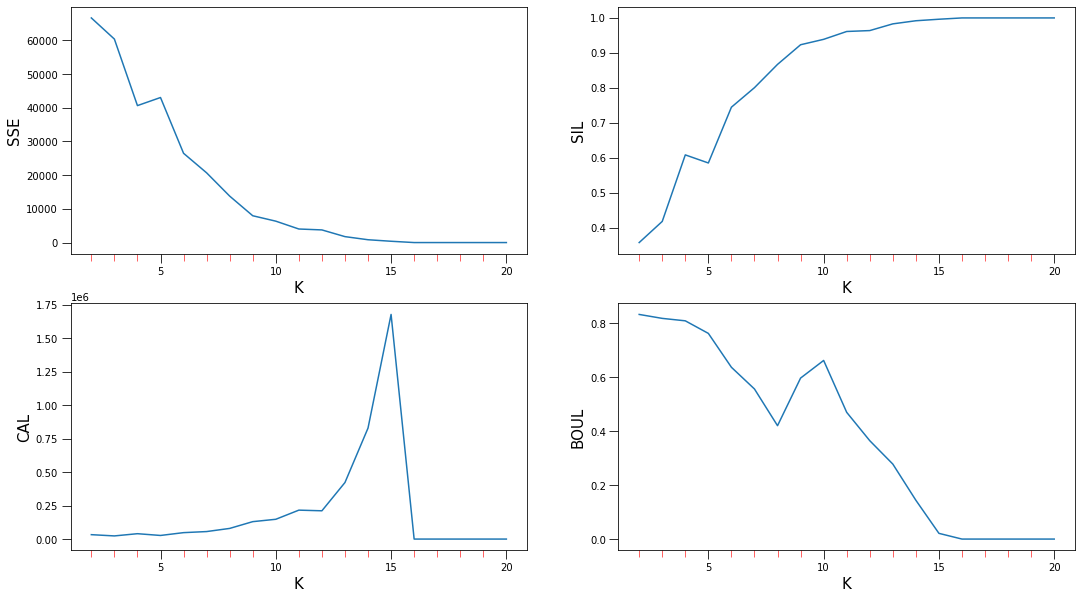

In [75]:
run_kmodes(df)

In [76]:
km = KModes(n_clusters = 9, init = 'Huang', n_init = 20, verbose = 0)
clusters = km.fit_predict(df)

n_clusters = len(np.unique(km.labels_))
        
sse = inertia(n_clusters, df, km.labels_)
       
sil = silhouette_score(df, km.labels_)
        
cal = calinski_harabasz_score(df, km.labels_)
       
boul = davies_bouldin_score(df, km.labels_)
 
print ('SSE: ', sse)
print ('Silhouette Score: ', sil)
print ("Calinski - Harabaz Score: ", cal)
print ("Davies - Bouldin Score: ", boul)

SSE:  7297.852609240861
Silhouette Score:  0.9296239766706822
Calinski - Harabaz Score:  142929.64633519595
Davies - Bouldin Score:  0.7035118854586337


In [77]:
df_confronto = df_orig.copy()
df_confronto['Labels'] = km.labels_

In [78]:
cluster_insight(df_confronto)

,Studio_Recording,Live_Recording,Tot_Cluster,Entropy,Purity
Cluster 0,8966,1401,10367,0.5714,0.8649
Cluster 1,7710,174,7884,0.1529,0.9779
Cluster 2,6527,49,6576,0.0634,0.9925
Cluster 3,18061,6126,24187,0.8164,0.7467
Cluster 4,5030,831,5861,0.5889,0.8582
Cluster 5,17749,348,18097,0.1371,0.9808
Cluster 6,21989,1241,23230,0.3008,0.9466
Cluster 7,4064,482,4546,0.4878,0.8940
Cluster 8,2087,873,2960,0.8750,0.7051
Total,92183,11525,103708,0.4341,0.8889


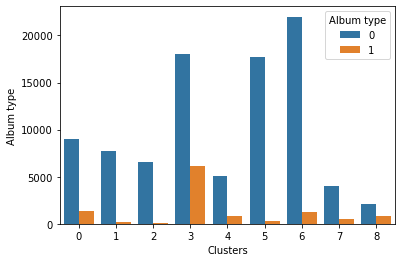

In [79]:
b = sns.countplot(x=df_confronto['Labels'], data=df_confronto, hue = df_confronto['album_type'])
b.set_xlabel("Clusters")
b.set_ylabel("Album type")
b.tick_params()
b.legend_.set_title('Album type')
b.grid(False)

In [81]:
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette

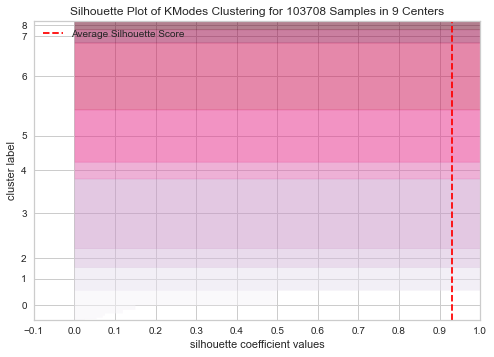

In [83]:
visualizer = SilhouetteVisualizer(km, colors='PuRd', is_fitted = True)

visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure